In [2]:
# Downloading PDFs
import requests
from bs4 import BeautifulSoup
import wget

# Data handling
import pandas as pd
import numpy as np
import datetime
import re

# Statistics
import statsmodels.tsa.x13 as sx13

# I/O
import os

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# set directory for files to be stored
DIR = "Data"
os.chdir(DIR)

### Reading and organizing data

In [24]:
''' Read in all tax data
Columns:
period - indicates yaer and quarter in format (YYYY Q[1-4])
original - non-seasonally adjusted value
adjusted - seasonally adjusted value*
state - indicates state with postal abbreviation. US denotes the total of all states except the District of Columbia.
category - indicates type of tax. Types included are:
    - Property 
    - General Sales and Gross Receipts 
    - Alcoholic Beverages Sales 
    - Amusements Sales 
    - Insurance Premiums Sales 
    - Motor Fuels Sales 
    - Pari-Mutuels Sales 
    - Public Utilities Sales 
    - Tobacco Products Sales 
    - Other Selective Sales and Gross Receipts 
    - Alcoholic Beverages License
    - Amusements License
    - Corporations in General License
    - Hunting and Fishing License
    - Motor Vehicles License
    - Motor Vehicles Operators License
    - Public Utilities License
    - Occupation and Business License
    - Other License 
    - Individual Income 
    - Corporation Net Income 
    - Death and Gift 
    - Documentary and Stock Transfer 
    - Severance 
    - Other Not Elsewhere Classified
    - Total 
    See dataset documentation for detail on category definitions.
    
*seasonally adjusted values obtained with X-13 SEATS procedure run with RJDMetra package in R. Used 
JDMetra 'RSA2c' preset specs: auto multiplicative/additive model detection; auto additive/level shift/temporary outlier detection;
trading day and Easter calendar effects (thinking was that they would affect sales/stock transfer/and possibly license taxes);
and the (0,1,1)(0,1,1) ARIMA model. 
'''

# Note: I did some initial data cleanup (e.g. renaming columns, deleting unneccessary columns, INDEX/MATCH-ing numerical keys
# with their corresponding English language values for ease of reference) in Excel. When I have some time I'll automate the
# data cleaning in pandas so new quarters can be added quickly.

file_path = "QTAX_adj.csv"
qtax_full = pd.read_csv(file_path, header = 0,parse_dates = [0])

In [38]:
#class QTax_Data():
    #def __init__(self, data = qtax_full):
        #self.data = data
        #self.totals


# Dict to reference dataframes by state names for easy file reading/writing
top_15_totals = {"california":'',
                 "texas":'',
                 "newyork":'',
                 "florida":'',
                 "pennsylvania":'',
                "illinois":'',
                 "ohio":'',
                 "georgia":'',
                 "northcarolina":'',
                 #"michigan":'', -- removing michigan because data appears to retain noticeable seasonality
                 # even after adjustment
                 "newjersey":'',
                 "virginia":'',
                "washington":'',
                 "arizona":'',
                 "massachusetts":''}
# State abbreviation dict to make switching between full name / abbr easier
abbr_lookup = {"alabama":"AL",
               "alaska":"AK",
               "arizona":"AZ",
               "arkansas":"AR",     
               "california":"CA",
               "colorado":"CO",
               "connecticut":"CT",
               "delaware":"DE",
               "florida":"FL",
               "georgia":"GA",
               "hawaii":"HI",
               "idaho":"ID",
               "illinois":"IL",
               "indiana":"IN",
               "iowa":"IA",
               "kansas":"KS",
               "kentucky":"KY",
               "louisiana":"LA",
               "maine":"ME",
               "maryland":"MD",
               "massachusetts":"MA",
               "michigan":"MI",
               "minnesota":"MN",
               "mississippi":"MS",
               "missouri":"MO",
               "montana":"MN",
               "nebraska":"NE",
               "nevada":"NV",
               "newhampshire":"NH",
               "newjersey":"NJ",
               "newmexico":"NM",
               "newyork":"NY",
               "northcarolina":"NC",
               "northdakota":"ND",
               "ohio":"OH",
               "oklahoma":"OK",
               "oregon":"OR",
               "pennsylvania":"PA",
               "rhodeisland":"RI",
               "southcarolina":"SC",
               "southdakota":"SD",
               "tennessee":"TN",     
               "texas":"TX",
               "utah":"UT",
               "vermont":"VT",                 
               "virginia":"VA",
               "washington":"WA",
               "westvirginia":"WV",
               "wisconsin":"WI",
               "wyoming":"WY"
                 }
by_state_data = {}
for state in abbr_lookup:
    by_state_data[state] = qtax_full[qtax_full.state == abbr_lookup[state]].pivot("period","category","adjusted")
    by_state_data[state].index = by_state_data[state].index.to_period(freq = "Q")
    for column in by_state_data[state].columns:
        by_state_data[state]["{}_q_pct_change".format(column)] = by_state_data[state][column].pct_change() 
        by_state_data[state]["{}_y_pct_change".format(column)] = by_state_data[state][column].pct_change(periods = 4) 


In [30]:
#def read_adj(state,cat = "total"):
    #return pd.read_csv("{}_{}_adj.csv".format(state,cat), header = 0,
                       #parse_dates = [0], infer_datetime_format = True)

#for key in top_15_totals:
    #top_15_totals[key] = read_adj(key)
    #top_15_totals[key].time = top_15_totals[key].time.str.replace(":","-Q")
    

In [31]:
# Add state column, quarterly percent change and yearly percent change, combine into single data frame for 
# graphing
top_15_total = pd.DataFrame(columns = ["time","original","adjusted","state","q_pct_change","y_pct_change"])
for key in top_15_totals:
    top_15_totals[key]["state"] = abbr_lookup[key]
    top_15_totals[key]["q_pct_change"] = top_15_totals[key]["adjusted"].pct_change()
    top_15_totals[key]["y_pct_change"] = top_15_totals[key]["original"].pct_change(periods = 4) # using original non- adjusted vals for y-y change
    top_15_total = top_15_total.append(top_15_totals[key])

In [20]:
top_15_total_val = top_15_total.pivot("time", "state", "adjusted")
top_15_total_val.index = top_15_total_val.index.to_period(freq = "Q")
top_15_total_val.head()

state            AZ            CA           FL           GA           IL  \
time                                                                       
1994Q1  1488.249300  12613.979470  4445.354218  7615.540557  3689.268742   
1994Q2  1516.326939  12157.203282  4537.776543  8968.645367  3829.658009   
1994Q3  1484.169233  12957.370181  4542.449951  8372.165640  3967.247159   
1994Q4  1527.552185  12801.546181  4583.086786  8411.323701  3945.200604   
1995Q1  1525.796998  13343.911683  4676.449616  7569.656637  4033.559887   

state            MA           NC           NJ           NY           OH  \
time                                                                      
1994Q1  2760.811653  2603.902221  3722.371662  7615.540557  3522.164592   
1994Q2  2732.888595  2761.257375  3648.518930  8968.645367  3565.962385   
1994Q3  2832.813156  2748.823759  3535.214393  8372.165640  3536.463251   
1994Q4  2797.343610  2789.291170  3493.986376  8411.323701  3641.822544   
1995Q1  3067.893918  2940.285389  3433.030217  7569.656637  3513.880094   

state            PA           TX           VA           WA  
time                                                        
1994Q1  4393.560012  4362.159343  2035.446552  2651.111533  
1994Q2  4364.161531  4435.308401  2064.063556  2190.203248  
1994Q3  4443.375192  4504.767216  2081.564086  2558.546475  
1994Q4  4567.621457  4630.306493  2107.155417  2556.616809  
1995Q1  4594.366604  4609.042689  2128.700272  2515.746804

## Total revenue heatmaps 

/Users/becca/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


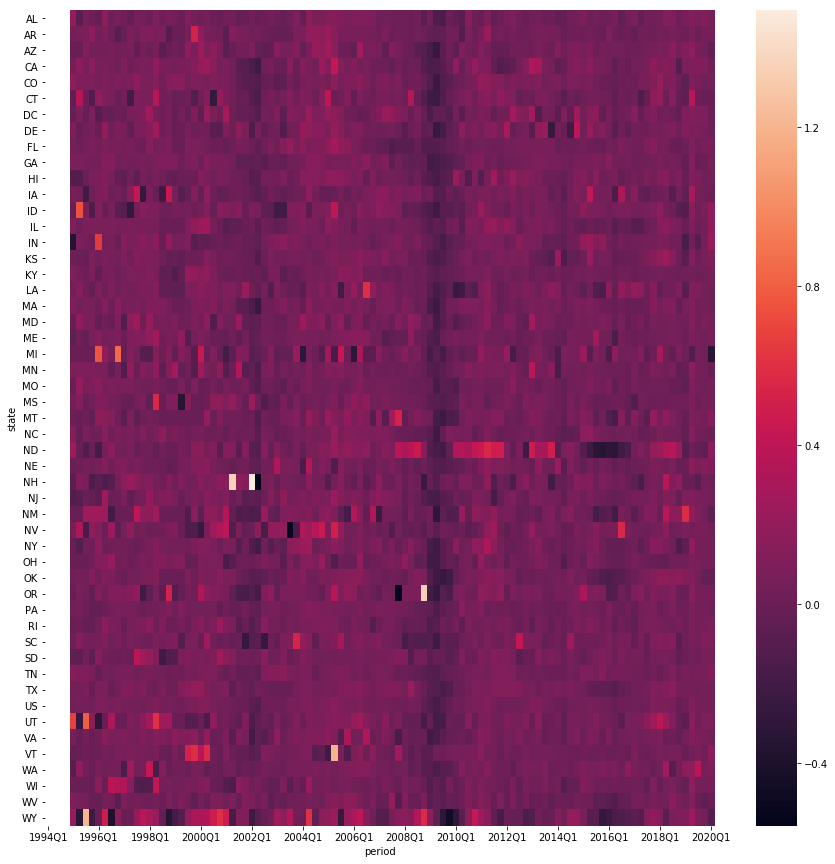

In [47]:
fig,ax = plt.subplots(figsize=(15,15))
totals_yoy = qtax_full[qtax_full.category == "Total"][qtax_full.state != "AK"].pivot("period","state","original")
totals_yoy.index = totals_yoy.index.to_period(freq = "Q")
for column in totals_yoy.columns:
    totals_yoy[column] = totals_yoy[column].pct_change(periods = 4)
sns.heatmap(totals_yoy.transpose(),ax = ax,xticklabels = 8)

/Users/becca/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


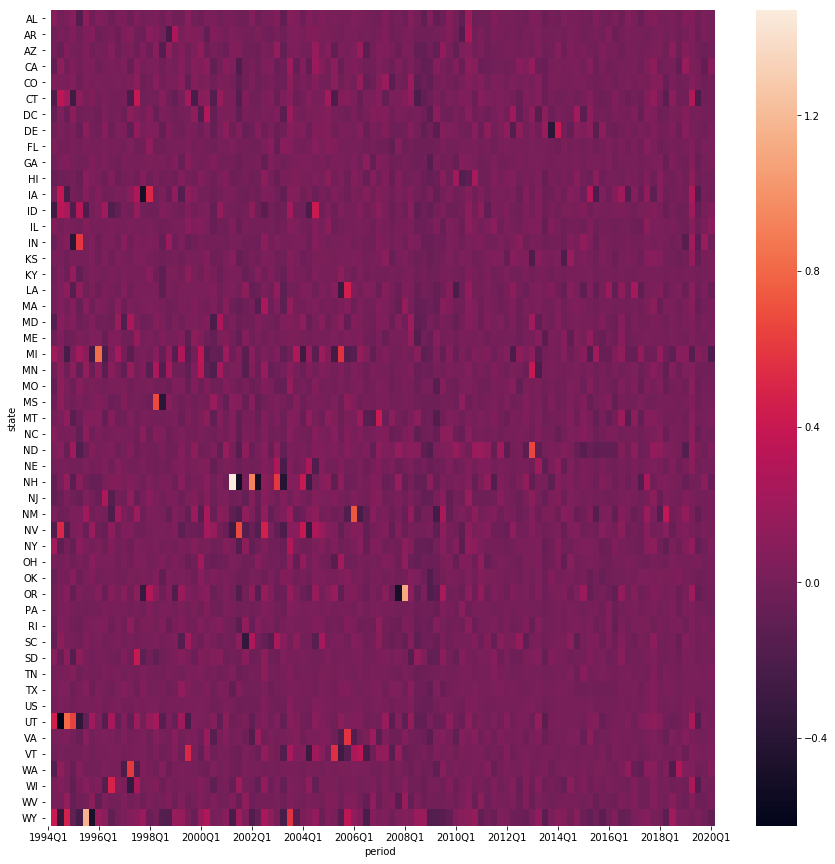

In [48]:
fig,ax = plt.subplots(figsize=(15,15))
totals_qoq = qtax_full[qtax_full.category == "Total"][qtax_full.state != "AK"].pivot("period","state","adjusted")
totals_qoq.index = totals_qoq.index.to_period(freq = "Q")
for column in totals_qoq.columns:
    totals_qoq[column] = totals_qoq[column].pct_change()
sns.heatmap(totals_qoq.transpose(),ax = ax,xticklabels = 8)

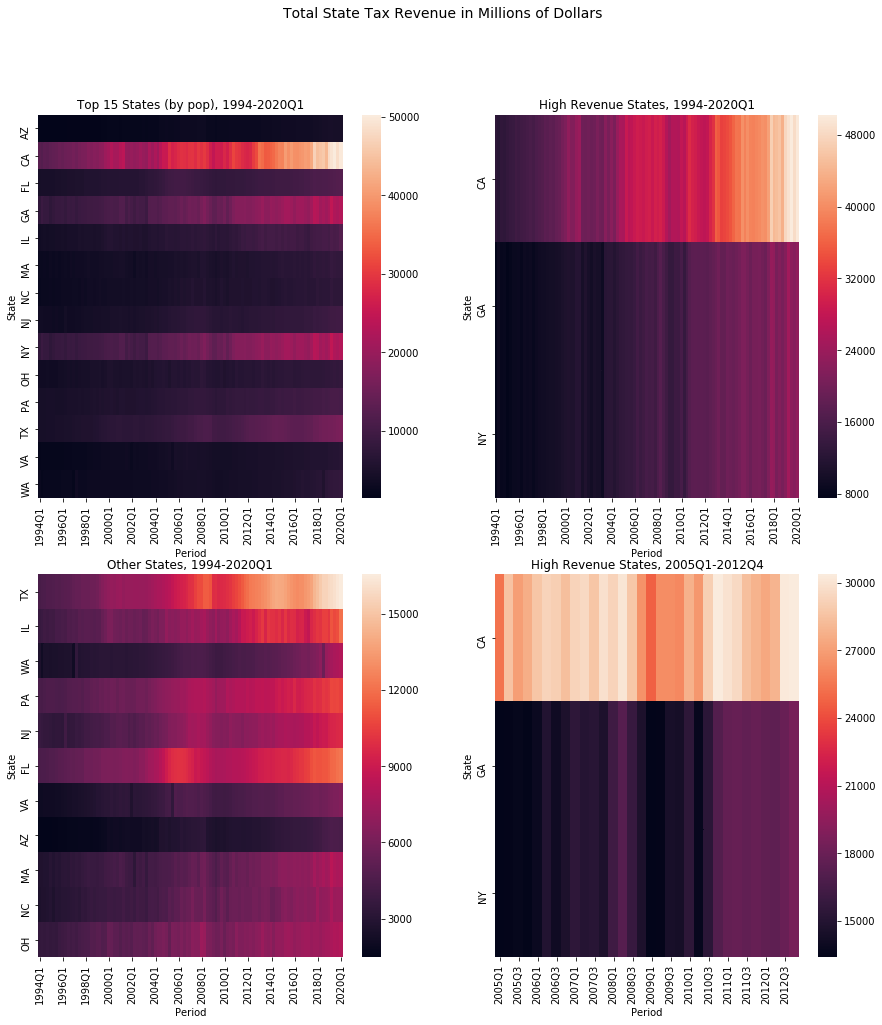

In [32]:
fig, axs = plt.subplots(2,2, figsize=(15,15))
ul = axs[0,0]
ur = axs[0,1]
ll = axs[1,0]
lr = axs[1,1]

sns.heatmap(top_15_total_val.transpose(),ax = ul,xticklabels = 8)
ul.set_ylabel("State")
ul.set_xlabel("Period")
ul.set_title("Top 15 States (by pop), 1994-2020Q1")
plt.subplots_adjust(bottom=.1)

# Isolate high revenue states
high_rev_states = ["CA","GA","NY"]
sns.heatmap(top_15_total_val[high_rev_states].transpose(),ax = ur,xticklabels = 8)
ur.set_ylabel("State")
ur.set_xlabel("Period")
ur.set_title("High Revenue States, 1994-2020Q1")

# Other states
other_states = list(set(top_15_total_val.columns) - set(high_rev_states))
sns.heatmap(top_15_total_val[other_states].transpose(),ax = ll,xticklabels = 8)
ll.set_ylabel("State")
ll.set_xlabel("Period")
ll.set_title("Other States, 1994-2020Q1")

# Zoom in on 2005-2012
sns.heatmap(top_15_total_val.loc[pd.Period('2005Q1'):pd.Period('2012Q4'),:][high_rev_states].transpose(),
            ax = lr,xticklabels = 2,robust = True)
lr.set_ylabel("State")
lr.set_xlabel("Period")
lr.set_title("High Revenue States, 2005Q1-2012Q4")
fig.suptitle("Total State Tax Revenue in Millions of Dollars",fontsize=14)
plt.show()

In [191]:
# Graph quarterly and yearly percent change
top_15_total_qchange = top_15_total.pivot("time", "state", "q_pct_change")
top_15_total_qchange.index = top_15_total_qchange.index.to_period(freq = "Q")
top_15_total_ychange = top_15_total.pivot("time", "state", "y_pct_change")
top_15_total_ychange.index = top_15_total_ychange.index.to_period(freq = "Q")

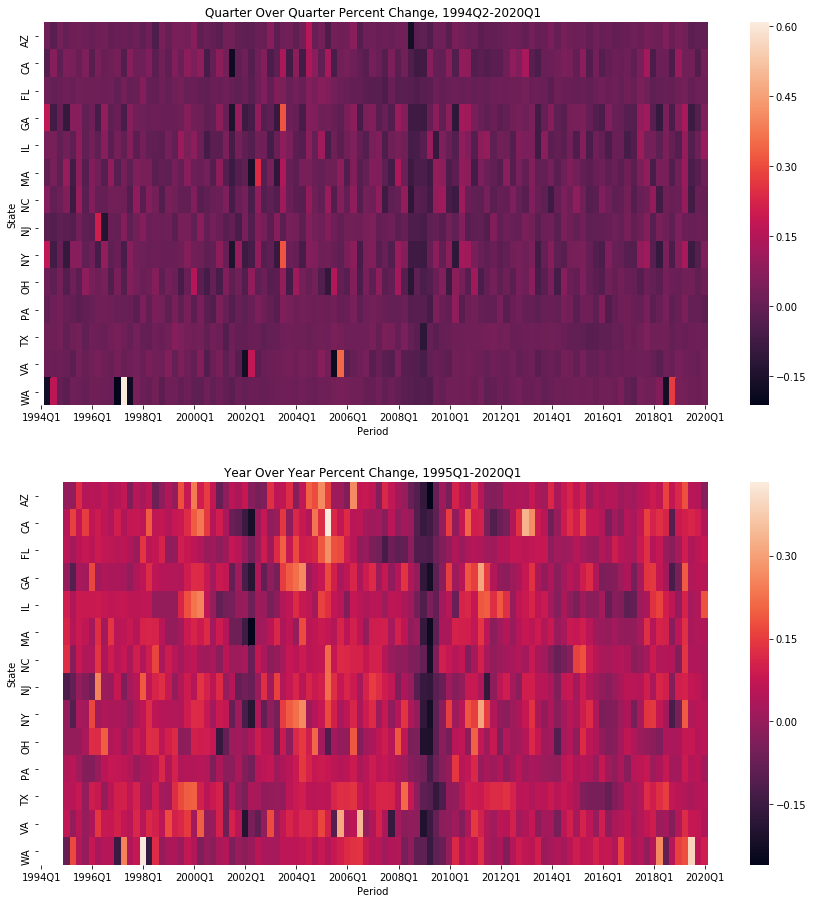

In [189]:
fig, (ax0,ax1) = plt.subplots(2,1,figsize=(15,15))
sns.heatmap(top_15_total_qchange.transpose(),ax = ax0,xticklabels = 8)
ax0.set_ylabel("State")
ax0.set_xlabel("Period")
ax0.set_title("Quarter Over Quarter Percent Change, 1994Q2-2020Q1")
plt.subplots_adjust(bottom=.1)
sns.heatmap(top_15_total_ychange.transpose(),ax = ax1,xticklabels = 8)
ax1.set_ylabel("State")
ax1.set_xlabel("Period")
ax1.set_title("Year Over Year Percent Change, 1995Q1-2020Q1")
plt.subplots_adjust(bottom=.1)

Notes:
* Outlier in Washington state during 1997, anomalous dip and spike. Attributable to volatile general
   sales and use taxes. Rate increases were approved in metro area for football stadium construction and new transi      system, also internet boom contributed to large sales tax increase.
* Outlier in California in 2005
* Florida revenue smoothest through recession (though decline begins earlier)
* States with severe dips in 2001-2002 also have severe dips in 2008-2009.

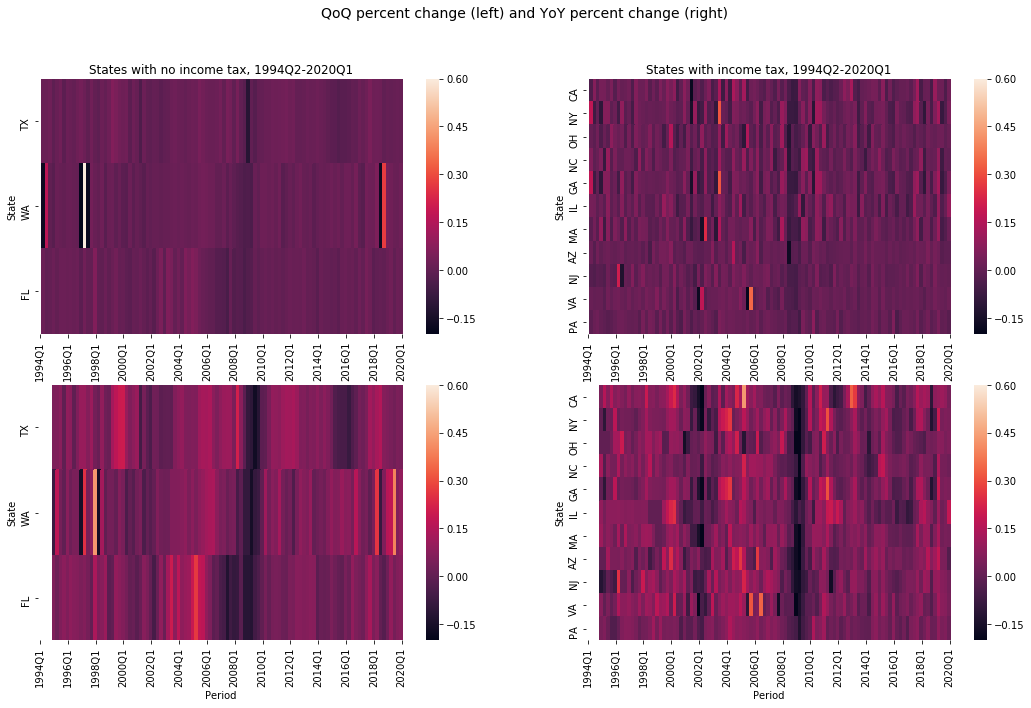

In [248]:
# Comparing states without income tax (FL, TX, WA) to states with income tax
no_income_tax = ['TX','WA','FL']
income_tax = list(set(top_15_total_qchange.columns) - set(no_income_tax))
min_ = -.2
max_ = .6
fig, axs = plt.subplots(2,2, figsize=(18,10))
ul = axs[0,0]
ur = axs[0,1]
ll = axs[1,0]
lr = axs[1,1]

sns.heatmap(top_15_total_qchange[no_income_tax].transpose(),ax = ul,xticklabels = 8, vmin = min_, vmax = max_)
ul.set_ylabel("State")
ul.set_xlabel("Period")
ul.set_title("States with no income tax, 1994Q2-2020Q1")
plt.subplots_adjust(bottom=.1)

sns.heatmap(top_15_total_qchange[income_tax].transpose(),ax = ur,xticklabels = 8,vmin = min_, vmax = max_)
ur.set_ylabel("State")
ur.set_xlabel("Period")
ur.set_title("States with income tax, 1994Q2-2020Q1")

sns.heatmap(top_15_total_ychange[no_income_tax].transpose(),ax = ll,xticklabels = 8,vmin = min_, vmax = max_)
ll.set_ylabel("State")
ll.set_xlabel("Period")

# Zoom in on 2005-2012
sns.heatmap(top_15_total_ychange[income_tax].transpose(),
            ax = lr,xticklabels = 8,vmin = min_, vmax = max_)
lr.set_ylabel("State")
lr.set_xlabel("Period")
fig.suptitle("QoQ percent change (top) and YoY percent change (bottom)",fontsize=14)
plt.show()

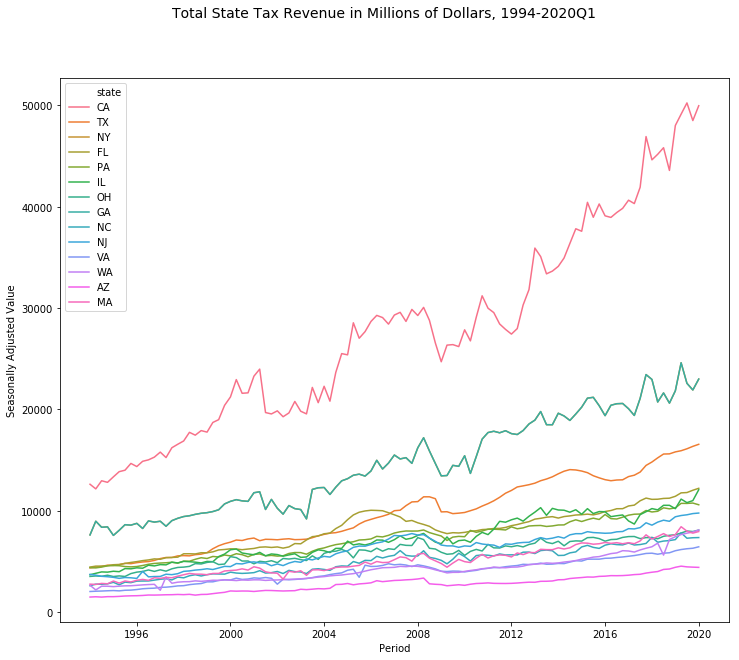

In [254]:
# Line plots
fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x = "time", y = "adjusted", data = top_15_total, hue = "state")
ax.set_xlabel("Period")
ax.set_ylabel("Seasonally Adjusted Value")
fig.suptitle("Total State Tax Revenue in Millions of Dollars, 1994-2020Q1",fontsize=14)
plt.show()

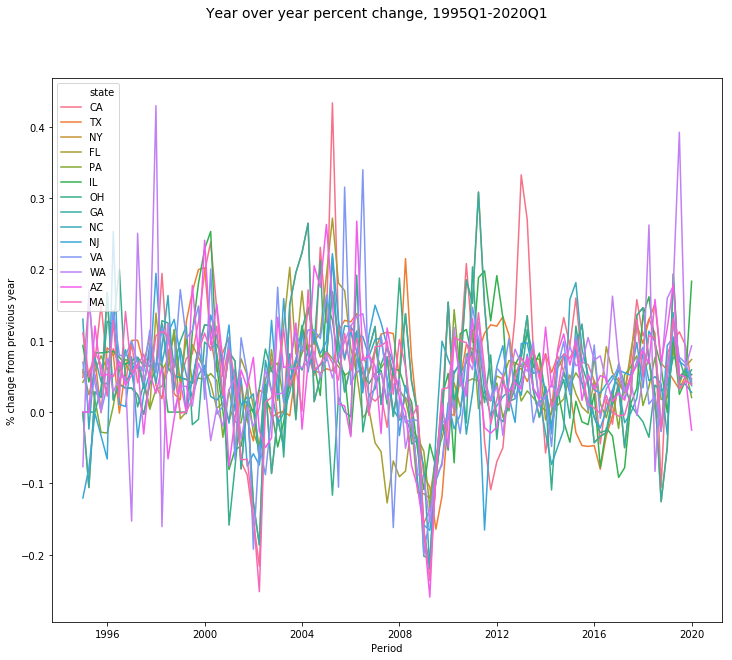

In [258]:
fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x = "time", y = "y_pct_change", data = top_15_total, hue = "state")
ax.set_xlabel("Period")
ax.set_ylabel("% change from previous year")
ax.legend(loc=2)
fig.suptitle("Year over year percent change, 1995Q1-2020Q1",fontsize=14)
plt.show()

In [267]:
# Add some unemployment data (from FRED via BLS)

unemployment = pd.read_csv("Data/Unemployment/state_unemployment.txt", sep = "\t",header = 0, parse_dates = [0])

In [268]:
unemployment.head()

DATE   AZ    CA   FL
0 2003-10-01  9.9  11.7  9.3
1 2004-01-01  9.7  11.6  9.1
2 2004-04-01  9.6  11.4  9.0
3 2004-07-01  9.1  11.2  8.6
4 2004-10-01  9.2  11.0  8.3

In [ ]:
# June 23 - July 1 To-Do
# go through annual survey for state / local revenue breakdown. Which states are more self sufficient versus which 
# dependent on particular localities. Some volatility because most stuff at local level. 
# What does local revenue look like. Which parts are more cyclical, less cyclical? Impute from annual survey about local 
# tax revenue. 
# Look at cyclical patterns with localities and states. Probably ok at annual level, need quarterly updating process
# Want to quickly anticipate revenue, on a quarterly basis
# LAUS unemployment statistics from FRED (State abbrev + UR)
# FRED payroll unemployment data

In [ ]:
"""Import local and state annual survey data
Source: U.S. Census Bureau, Annual Survey of State and Local Government Finances and Census of Governments (1977-2017) 
via the State and Local Finance Data Query System, Urban-Brookings Tax Policy Center
"""

